In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
pip install scikeras optuna

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from keras.optimizers import SGD

In [51]:
file_path = '/content/drive/My Drive/crypto_data/xrp_spots_1hour.csv'
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df

,open,high,low,close,volume
date,,,,,
2018-05-04 15:00:00,0.50000,1.50000,0.5000,0.92300,5090857.33
2018-05-04 16:00:00,0.92300,0.92850,0.9010,0.90199,3326696.10
2018-05-04 17:00:00,0.90199,0.91027,0.8951,0.90128,1176810.48
2018-05-04 18:00:00,0.90128,0.92130,0.8800,0.91596,1714233.92
2018-05-04 19:00:00,0.91596,0.92450,0.9000,0.90098,1323800.17
...,...,...,...,...,...
2024-08-12 02:00:00,0.56900,0.56900,0.5589,0.55930,19062997.00
2024-08-12 03:00:00,0.55930,0.55960,0.5492,0.55200,35705424.00
2024-08-12 04:00:00,0.55200,0.55650,0.5490,0.55510,15354450.00


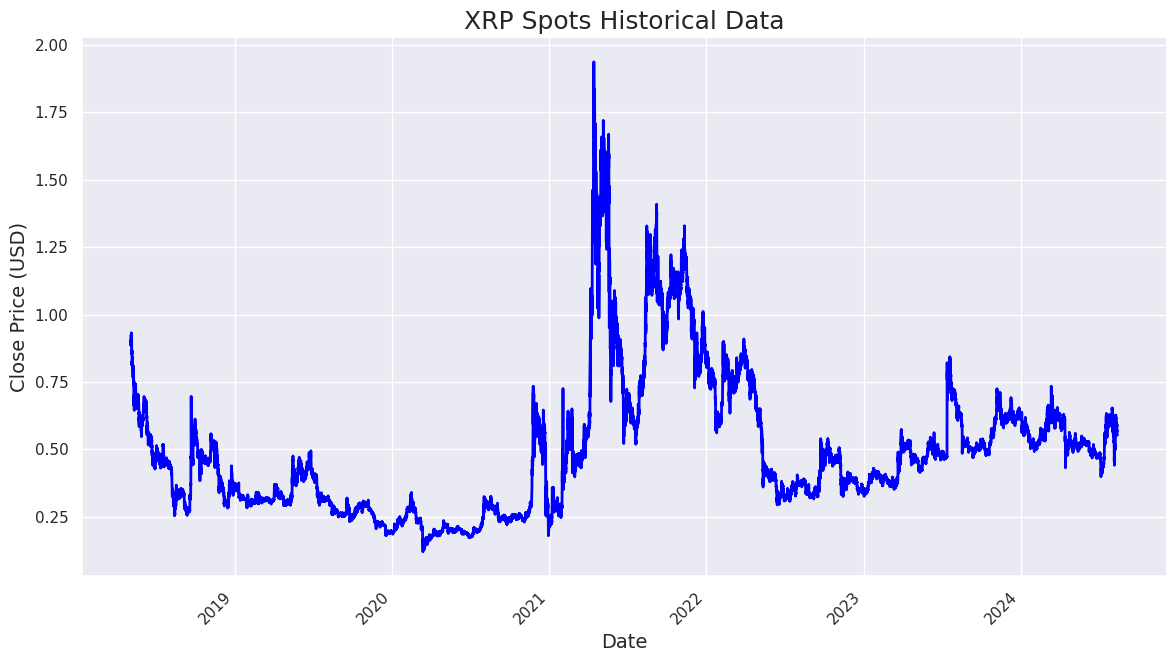

In [52]:
plt.figure(figsize=(14, 7))
plt.plot(df['close'], color='blue', linewidth=2)

plt.title("XRP Spots Historical Data", fontsize=18)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Close Price (USD)", fontsize=14)

plt.xticks(rotation=45, ha='right')

plt.grid(True)

plt.show()

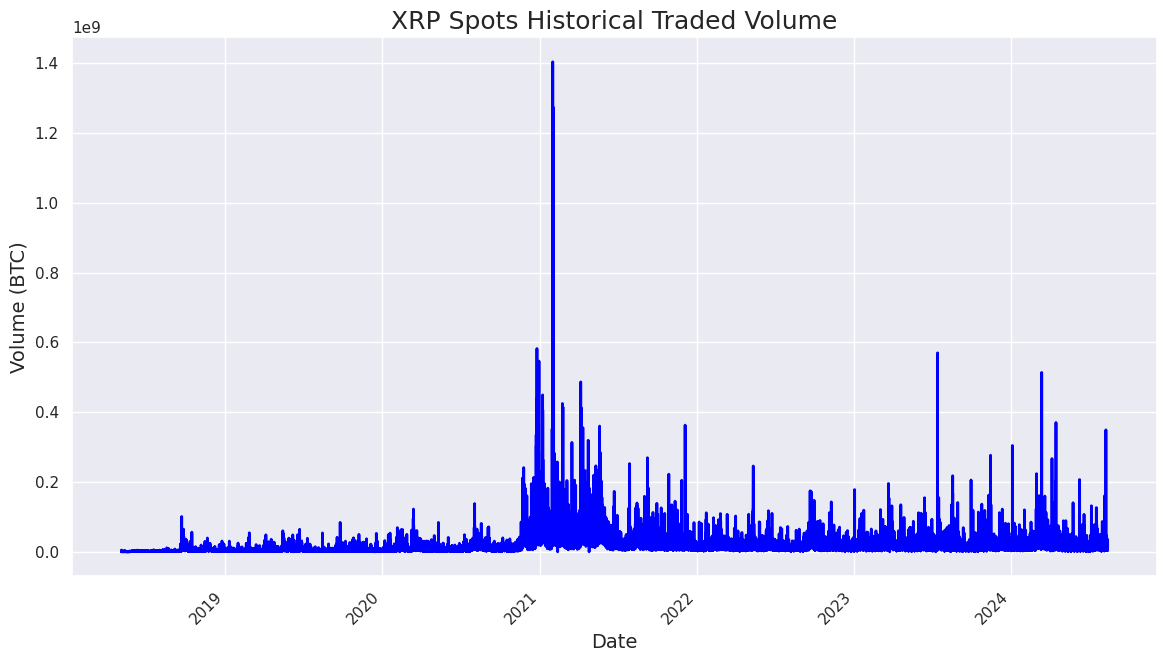

In [53]:
plt.figure(figsize=(14, 7))
plt.plot(df['volume'], color='blue', linewidth=2)

plt.title("XRP Spots Historical Traded Volume", fontsize=18)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Volume (BTC)", fontsize=14)

plt.xticks(rotation=45, ha='right')

plt.grid(True)

plt.show()

In [54]:
datamodel = df.copy()
datamodel['return'] = datamodel['close'].pct_change().fillna(0)
for lag in [1, 2, 3, 4, 5]:
    datamodel[f'lag_{lag}'] = datamodel['return'].shift(lag)
datamodel['direction'] = np.where(datamodel['return'] > 0, 1, 0)
def hurst_exponent(ts, max_lag=20):
    lags = range(2, max_lag)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]*2.0

datamodel['hurst_exponent'] = datamodel['close'].rolling(window=100).apply(hurst_exponent, raw=True)

In [55]:
def EMA(df, n):
    EMA = pd.Series(df['close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
datamodel['EMA10'] = EMA(datamodel, 10)
datamodel['EMA30'] = EMA(datamodel, 30)
datamodel['EMA200'] = EMA(datamodel, 200)

def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))
    return ROC
datamodel['ROC10'] = ROC(datamodel['close'], 10)
datamodel['ROC30'] = ROC(datamodel['close'], 30)

def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
datamodel['MOM10'] = MOM(datamodel['close'], 10)
datamodel['MOM30'] = MOM(datamodel['close'], 30)

def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
datamodel['RSI10'] = RSI(datamodel['close'], 10)
datamodel['RSI30'] = RSI(datamodel['close'], 30)
datamodel['RSI200'] = RSI(datamodel['close'], 200)

def STOK(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

def MA(df, n):
    MA = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA

In [56]:
datamodel['%K10'] = STOK(datamodel['close'], datamodel['low'], datamodel['high'], 10)
datamodel['%D10'] = STOD(datamodel['close'], datamodel['low'], datamodel['high'], 10)
datamodel['%K30'] = STOK(datamodel['close'], datamodel['low'], datamodel['high'], 30)
datamodel['%D30'] = STOD(datamodel['close'], datamodel['low'], datamodel['high'], 30)
datamodel['%K200'] = STOK(datamodel['close'], datamodel['low'], datamodel['high'], 200)
datamodel['%D200'] = STOD(datamodel['close'], datamodel['low'], datamodel['high'], 200)
datamodel['MA21'] = MA(datamodel, 10)
datamodel['MA63'] = MA(datamodel, 30)
datamodel['MA252'] = MA(datamodel, 200)

In [57]:
datamodel = datamodel.fillna(0)
datamodel

,open,high,low,close,volume,return,lag_1,lag_2,lag_3,lag_4,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
date,,,,,,,,,,,,,,,,,,,,,
2018-05-04 15:00:00,0.50000,1.50000,0.5000,0.92300,5090857.33,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2018-05-04 16:00:00,0.92300,0.92850,0.9010,0.90199,3326696.10,-0.022763,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2018-05-04 17:00:00,0.90199,0.91027,0.8951,0.90128,1176810.48,-0.000787,-0.022763,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2018-05-04 18:00:00,0.90128,0.92130,0.8800,0.91596,1714233.92,0.016288,-0.000787,-0.022763,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2018-05-04 19:00:00,0.91596,0.92450,0.9000,0.90098,1323800.17,-0.016354,0.016288,-0.000787,-0.022763,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12 02:00:00,0.56900,0.56900,0.5589,0.55930,19062997.00,-0.016875,-0.002280,0.002285,0.003882,-0.001410,...,49.394214,1.666667,15.651517,0.928074,11.730678,60.236407,63.467297,0.57066,0.584093,0.552934
2024-08-12 03:00:00,0.55930,0.55960,0.5492,0.55200,35705424.00,-0.013052,-0.016875,-0.002280,0.002285,0.003882,...,48.994555,8.668731,10.291373,5.303030,7.237779,56.784870,60.598897,0.56782,0.582597,0.552848
2024-08-12 04:00:00,0.55200,0.55650,0.5490,0.55510,15354450.00,0.005616,-0.013052,-0.016875,-0.002280,0.002285,...,49.170084,22.181818,10.839072,11.708253,5.979786,58.250591,58.423956,0.56575,0.581187,0.552768


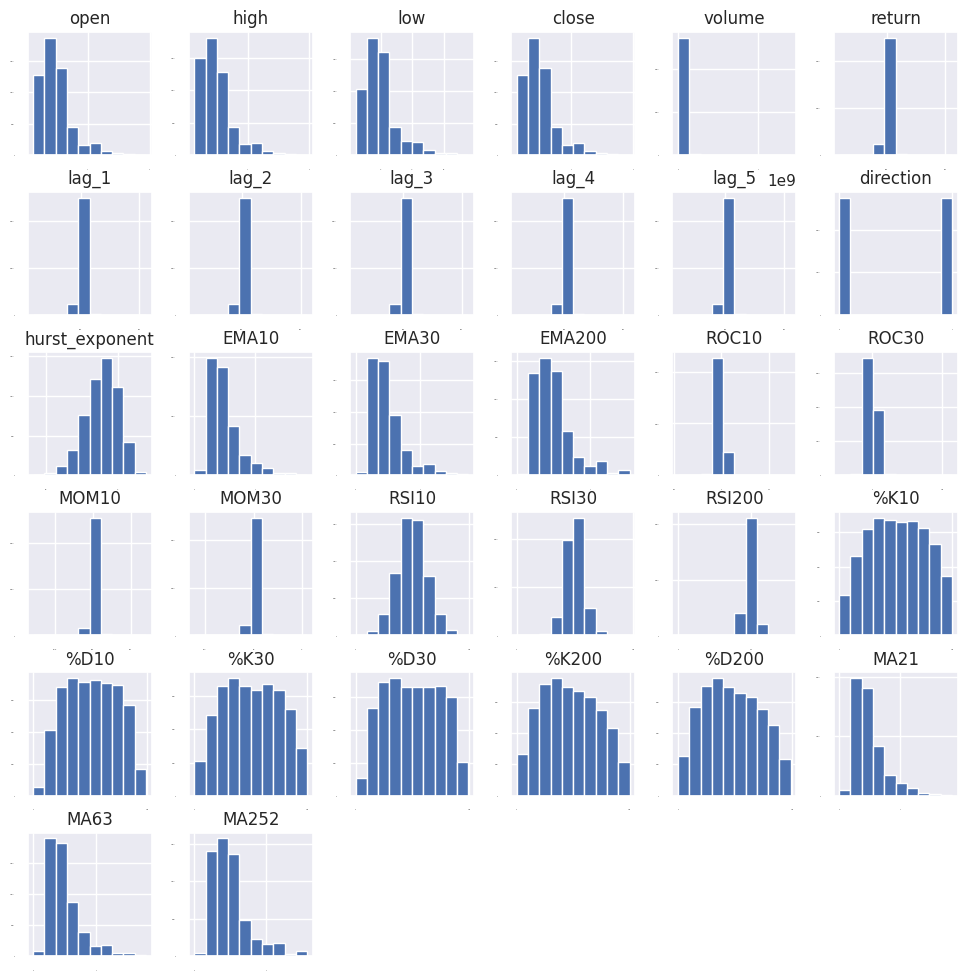

In [58]:
datamodel.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

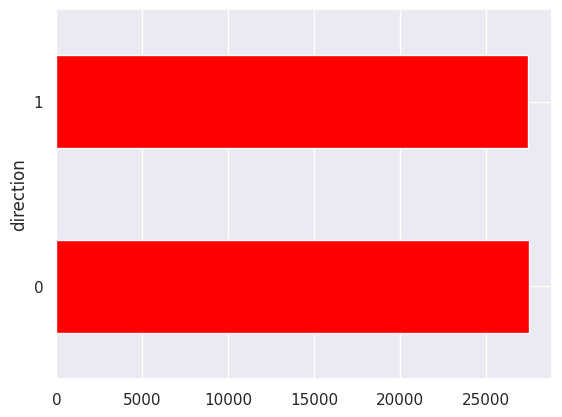

In [59]:
fig = plt.figure()
plot = datamodel.groupby(['direction']).size().plot(kind='barh', color='red')
plt.show()

<Axes: title={'center': 'Correlation Matrix'}>

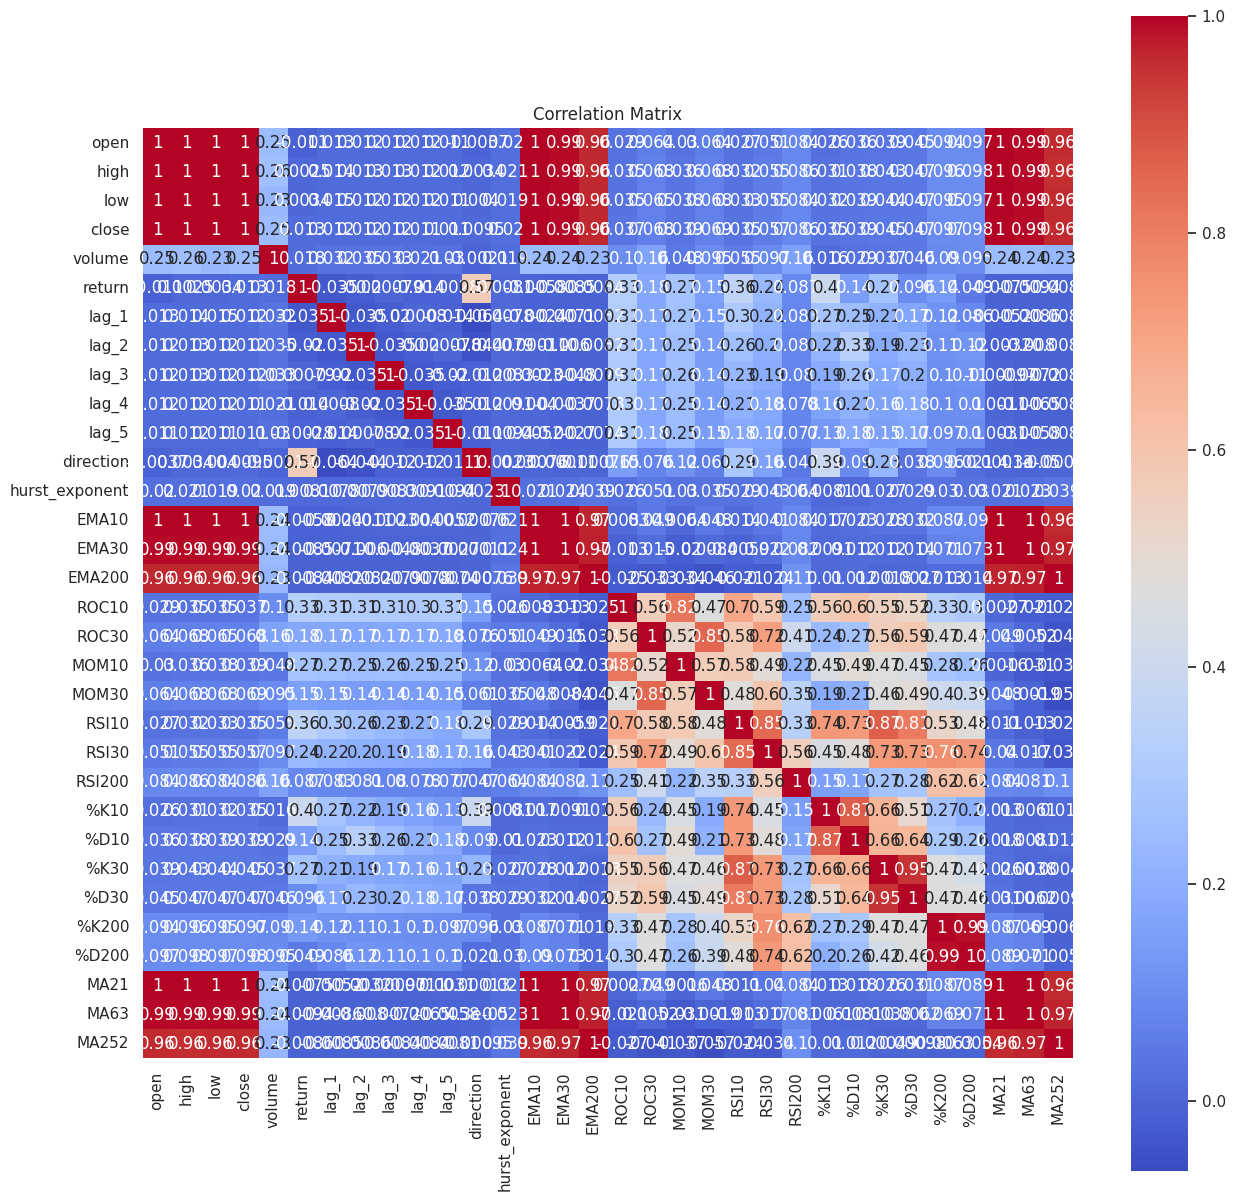

In [60]:
correlation = datamodel.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='coolwarm')

In [61]:
datamodel=datamodel.drop(['close', 'return', 'high','low','open', 'volume', 'EMA10' ,'EMA30', 'EMA200', 'MA21', 'MA63', 'MA252'], axis=1)
datamodel.head(5)

,lag_1,lag_2,lag_3,lag_4,lag_5,direction,hurst_exponent,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200
date,,,,,,,,,,,,,,,,,,,,
2018-05-04 15:00:00,0.000000,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-04 16:00:00,0.000000,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-04 17:00:00,-0.022763,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-04 18:00:00,-0.000787,-0.022763,0.000000,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-04 19:00:00,0.016288,-0.000787,-0.022763,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
train = datamodel.iloc[:-10000]
test = datamodel.iloc[-10000:]

Y_train_full = train["direction"]
X_train_full = train.loc[:, ~train.columns.isin(['direction'])]

Y_test = test["direction"]
X_test = test.loc[:, ~test.columns.isin(['direction'])]

validation_size = int(len(X_train_full) * 0.2)
X_train = X_train_full.iloc[:-validation_size]
X_validation = X_train_full.iloc[-validation_size:]
Y_train = Y_train_full.iloc[:-validation_size]
Y_validation = Y_train_full.iloc[-validation_size:]

print(f"Training set: {X_train.shape}, Validation set: {X_validation.shape}")
print(f"Test set: {X_test.shape}")

Training set: (35930, 19), Validation set: (8982, 19)
Test set: (10000, 19)


In [63]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

#Neural Network
models.append(('NN', MLPClassifier()))

# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

In [64]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from joblib import parallel_backend
results = []
names = []

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

ts_split = TimeSeriesSplit(n_splits=5)

with parallel_backend('threading'):
    for name, model in models:
        cv_results = cross_val_score(model, X_train_scaled, Y_train, cv=ts_split, scoring='accuracy')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)


LR: 0.880060 (0.008805)
LDA: 0.866733 (0.007566)
KNN: 0.754476 (0.014348)
CART: 0.802238 (0.011861)
NB: 0.610688 (0.004978)
NN: 0.912826 (0.010695)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

AB: 0.842084 (0.006825)
GBM: 0.860788 (0.009543)
RF: 0.867468 (0.012161)


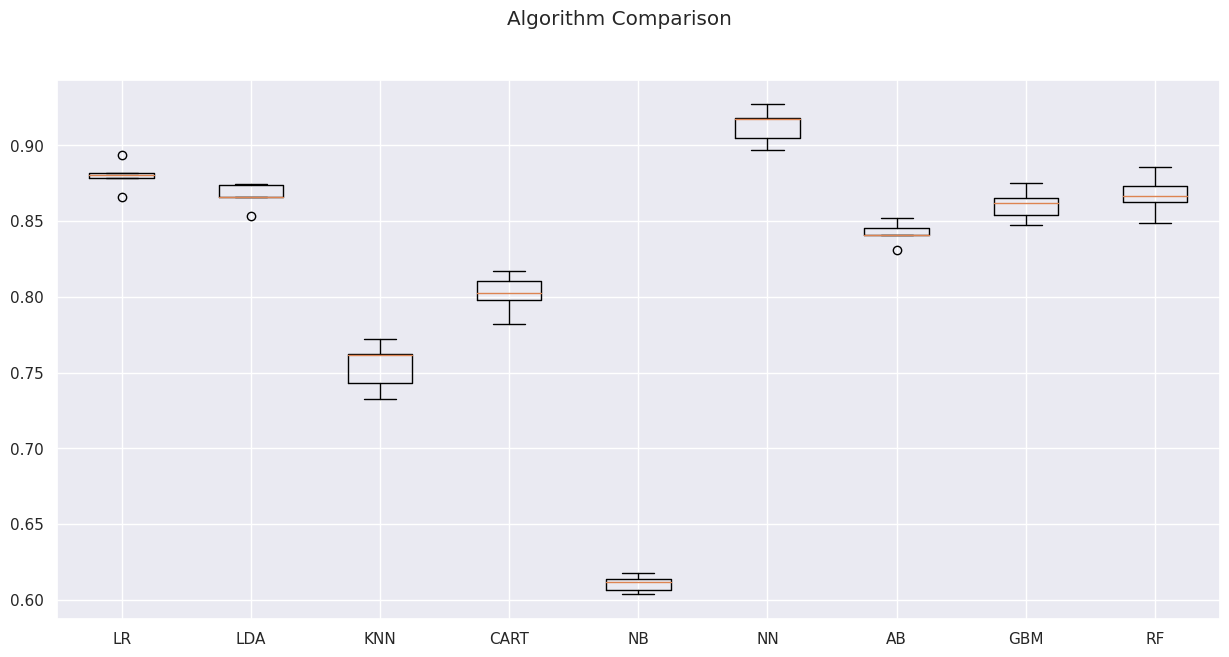

In [65]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,7)
plt.show()

In [66]:
import optuna
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

def objective(trial):
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear'])
    C = trial.suggest_float('C', 1e-3, 1e1, log=True)
    max_iter = trial.suggest_int('max_iter', 500, 4000)

    param = {
        'solver': solver,
        'C': C,
        'max_iter': max_iter
    }

    ts_split = TimeSeriesSplit(n_splits=5)
    accuracy_scores = []

    for train_idx, val_idx in ts_split.split(rescaledX):
        X_train_fold, X_val_fold = rescaledX[train_idx], rescaledX[val_idx]
        Y_train_fold, Y_val_fold = Y_train.iloc[train_idx], Y_train.iloc[val_idx]

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            model = LogisticRegression(**param)
            model.fit(X_train_fold, Y_train_fold)

        preds = model.predict(X_val_fold)
        accuracy = accuracy_score(Y_val_fold, preds)
        accuracy_scores.append(accuracy)

    return np.mean(accuracy_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f"Best Accuracy: {study.best_value}")
print(f"Best Parameters: {study.best_params}")

[I 2024-08-14 03:21:37,488] A new study created in memory with name: no-name-610dc8b3-614c-42c9-b588-44c48ce1a7e7
[I 2024-08-14 03:21:37,860] Trial 0 finished with value: 0.8743152972611892 and parameters: {'solver': 'newton-cg', 'C': 0.26969105834033513, 'max_iter': 2132}. Best is trial 0 with value: 0.8743152972611892.
[I 2024-08-14 03:21:38,156] Trial 1 finished with value: 0.8706078824315296 and parameters: {'solver': 'newton-cg', 'C': 0.08961686645653821, 'max_iter': 2728}. Best is trial 0 with value: 0.8743152972611892.
[I 2024-08-14 03:21:38,336] Trial 2 finished with value: 0.8267869071476286 and parameters: {'solver': 'lbfgs', 'C': 0.001825218872886384, 'max_iter': 2396}. Best is trial 0 with value: 0.8743152972611892.
[I 2024-08-14 03:21:39,308] Trial 3 finished with value: 0.8810287241148963 and parameters: {'solver': 'liblinear', 'C': 1.270356539614172, 'max_iter': 3417}. Best is trial 3 with value: 0.8810287241148963.
[I 2024-08-14 03:21:39,508] Trial 4 finished with value

Best Accuracy: 0.8857715430861723
Best Parameters: {'solver': 'newton-cg', 'C': 9.99265329579324, 'max_iter': 2045}


In [71]:
import joblib

best_params = study.best_params
best_model = LogisticRegression(**best_params)
best_model.fit(rescaledX, Y_train)

model_filename = 'best_logistic_regression_model.pkl'
joblib.dump(best_model, model_filename)

print(f"Model saved to {model_filename}.")

Model saved to best_logistic_regression_model.pkl.


In [72]:
predictions = best_model.predict(X_validation_scaled)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.8853262079714985
[[3879  558]
 [ 472 4073]]
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4437
           1       0.88      0.90      0.89      4545

    accuracy                           0.89      8982
   macro avg       0.89      0.89      0.89      8982
weighted avg       0.89      0.89      0.89      8982



<Axes: xlabel='Predicted', ylabel='Actual'>

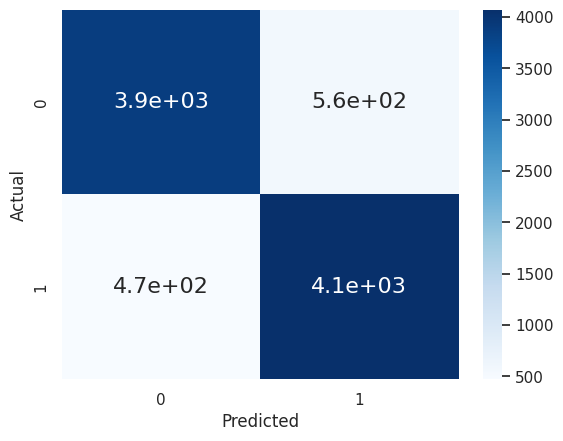

In [73]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

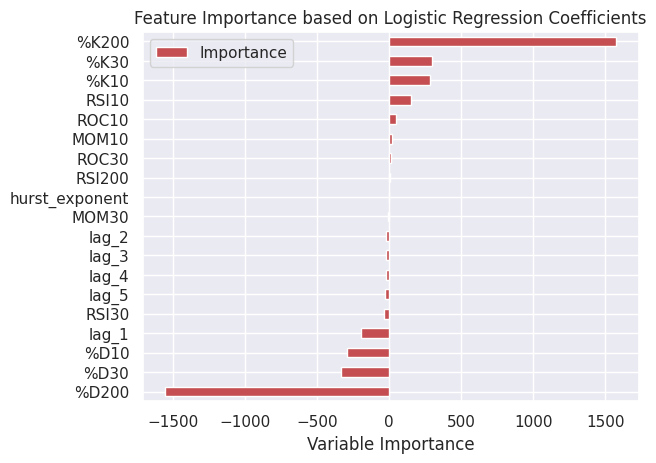

In [74]:
coefficients = best_model.coef_[0]

Importance = pd.DataFrame({'Importance': coefficients * 100}, index=X_train_full.columns)

Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r')
plt.xlabel('Variable Importance')
plt.title('Feature Importance based on Logistic Regression Coefficients')
plt.show()

In [75]:
X_test_scaled = scaler.transform(X_test)

test_predictions = best_model.predict(X_test_scaled)

test_accuracy = accuracy_score(Y_test, test_predictions)
test_confusion_matrix = confusion_matrix(Y_test, test_predictions)
test_classification_report = classification_report(Y_test, test_predictions)

print(f"Test Accuracy: {test_accuracy}")
print("Test Confusion Matrix:")
print(test_confusion_matrix)
print("Test Classification Report:")
print(test_classification_report)

Test Accuracy: 0.8822
Test Confusion Matrix:
[[4386  596]
 [ 582 4436]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4982
           1       0.88      0.88      0.88      5018

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



<Axes: xlabel='Predicted', ylabel='Actual'>

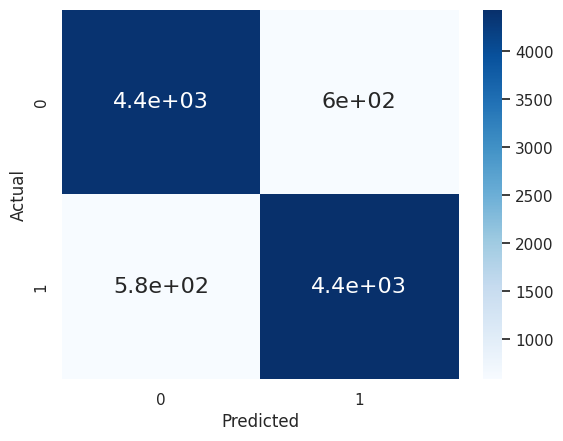

In [76]:
df_cm = pd.DataFrame(confusion_matrix(Y_test, test_predictions), columns=np.unique(Y_test), index = np.unique(Y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

In [77]:
insample = df[:-10000]
outsample = df[-10000:]

In [78]:
outsample

,open,high,low,close,volume
date,,,,,
2023-06-22 15:00:00,0.5122,0.5129,0.5087,0.5095,13538962.0
2023-06-22 16:00:00,0.5095,0.5108,0.5067,0.5089,15149968.0
2023-06-22 17:00:00,0.5090,0.5112,0.5080,0.5084,13002557.0
2023-06-22 18:00:00,0.5083,0.5086,0.4821,0.4935,70501604.0
2023-06-22 19:00:00,0.4936,0.5001,0.4929,0.4983,27859112.0
...,...,...,...,...,...
2024-08-12 02:00:00,0.5690,0.5690,0.5589,0.5593,19062997.0
2024-08-12 03:00:00,0.5593,0.5596,0.5492,0.5520,35705424.0
2024-08-12 04:00:00,0.5520,0.5565,0.5490,0.5551,15354450.0


In [86]:
something = datamodel.copy()
something['return'] = df['close'].pct_change().fillna(0)
something

,lag_1,lag_2,lag_3,lag_4,lag_5,direction,hurst_exponent,ROC10,ROC30,MOM10,...,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,return
date,,,,,,,,,,,,,,,,,,,,,
2018-05-04 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-05-04 16:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.022763
2018-05-04 17:00:00,-0.022763,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000787
2018-05-04 18:00:00,-0.000787,-0.022763,0.000000,0.000000,0.000000,1,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016288
2018-05-04 19:00:00,0.016288,-0.000787,-0.022763,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.016354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12 02:00:00,-0.002280,0.002285,0.003882,-0.001410,-0.010290,0,0.234201,-3.635424,-6.299213,-0.0209,...,19.834194,38.306664,49.394214,1.666667,15.651517,0.928074,11.730678,60.236407,63.467297,-0.016875
2024-08-12 03:00:00,-0.016875,-0.002280,0.002285,0.003882,-0.001410,0,0.216393,-4.133380,-7.599598,-0.0284,...,15.729561,35.647771,48.994555,8.668731,10.291373,5.303030,7.237779,56.784870,60.598897,-0.013052
2024-08-12 04:00:00,-0.013052,-0.016875,-0.002280,0.002285,0.003882,1,0.223540,-3.544744,-6.799866,-0.0207,...,23.226240,37.551949,49.170084,22.181818,10.839072,11.708253,5.979786,58.250591,58.423956,0.005616


<Axes: xlabel='date'>

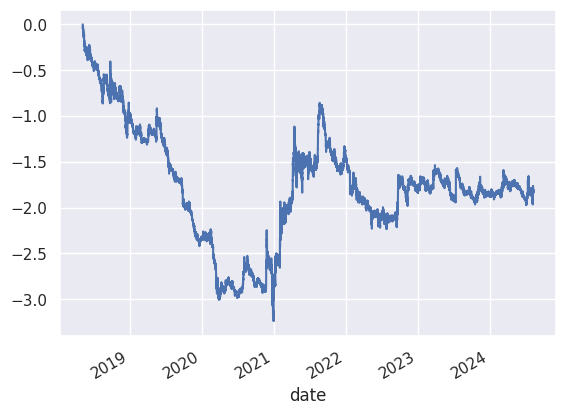

In [88]:
(something['return']*something['direction'].shift(1)).cumsum().plot()

In [129]:
backtestdata = pd.DataFrame(index=outsample.index)

backtestdata['predictions'] = test_predictions
backtestdata['close'] = outsample['close']
backtestdata['position'] = backtestdata['predictions'].shift(5)
backtestdata['position'] = np.where(backtestdata['position'] == 1, 1, 0)
backtestdata['pnl'] = backtestdata['close'].diff() * backtestdata['position'].shift(1)
backtestdata['pnl'].fillna(0, inplace=True)

backtestdata


,predictions,close,position,pnl
date,,,,
2023-06-22 15:00:00,0,0.5095,0,0.000
2023-06-22 16:00:00,0,0.5089,0,-0.000
2023-06-22 17:00:00,0,0.5084,0,-0.000
2023-06-22 18:00:00,0,0.4935,0,-0.000
2023-06-22 19:00:00,1,0.4983,0,0.000
...,...,...,...,...
2024-08-12 02:00:00,0,0.5593,0,-0.000
2024-08-12 03:00:00,0,0.5520,0,-0.000
2024-08-12 04:00:00,1,0.5551,1,0.000


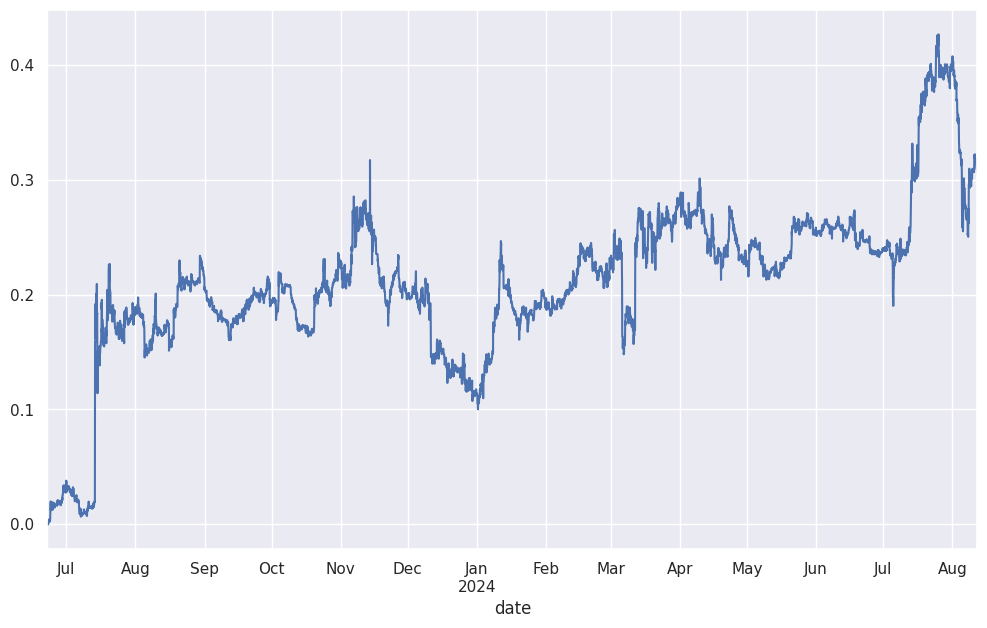

In [130]:
backtestdata['pnl'].cumsum().plot(figsize=(12, 7))
plt.show()

<Axes: xlabel='date'>

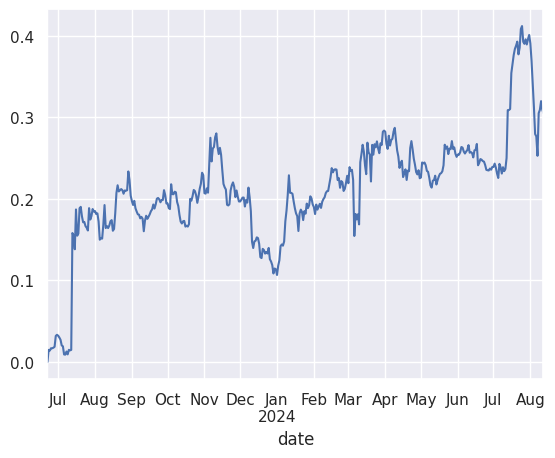

In [131]:
daily_pnl = backtestdata['pnl'].resample('D').sum()
daily_pnl.cumsum().plot()

In [132]:
(daily_pnl.mean() / daily_pnl.std()) * np.sqrt(252)

0.7835126352863953